Found 8 files matching pattern '*.csv'
Processing Rec-0003_253.csv...
Saved cleaned file to E:\Gaurav\Honeywell\Experimental Data\Gaurav\Extracted_1000_images_from_experimental_trail1_data\testing python code\cleaned_Rec-0003_253.csv
Processing Rec-0003_92.csv...
Saved cleaned file to E:\Gaurav\Honeywell\Experimental Data\Gaurav\Extracted_1000_images_from_experimental_trail1_data\testing python code\cleaned_Rec-0003_92.csv
Processing Rec-0003_115.csv...
Saved cleaned file to E:\Gaurav\Honeywell\Experimental Data\Gaurav\Extracted_1000_images_from_experimental_trail1_data\testing python code\cleaned_Rec-0003_115.csv
Processing Rec-0003_138.csv...
Saved cleaned file to E:\Gaurav\Honeywell\Experimental Data\Gaurav\Extracted_1000_images_from_experimental_trail1_data\testing python code\cleaned_Rec-0003_138.csv
Processing Rec-0003_161.csv...
Saved cleaned file to E:\Gaurav\Honeywell\Experimental Data\Gaurav\Extracted_1000_images_from_experimental_trail1_data\testing python code\cleaned_Rec-0

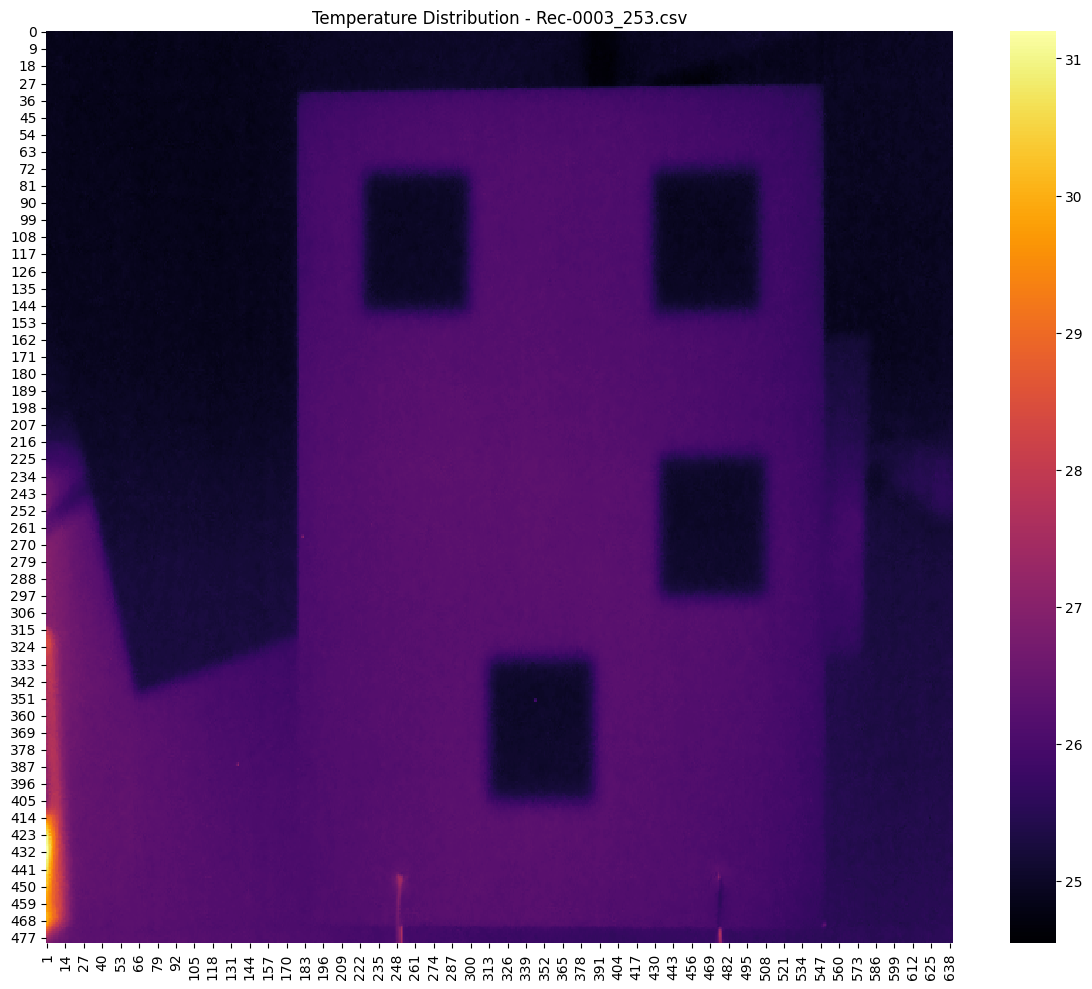

In [4]:
#!/usr/bin/env python3
"""
FLIR CSV Temperature Data Cleaner using Pandas

This script cleans FLIR thermal camera CSV files by:
1. Removing camera information metadata rows from the beginning
2. Processing all files in a specified folder
3. Returns pandas DataFrames for further analysis

Usage:
- Import this module in your data analysis scripts
- Use the provided functions to clean and load your FLIR CSV files
- Cleaned files can also be saved with a "cleaned_" prefix
"""

import os
import re
import glob
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Any, Optional, Union


def find_data_start(file_path: str) -> int:
    """
    Determine the row where temperature data starts in a FLIR CSV file
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        The row index where temperature data begins
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    for i, line in enumerate(lines):
        # Look for a row that might be the start of temperature data
        if line.strip() and line.count(',') > 5:
            # Check if this line has multiple numeric values
            cells = line.split(',')
            numeric_cells = [c for c in cells if c.strip() and is_numeric(c.strip())]
            if len(numeric_cells) > 5:
                return i
    
    # Default to row 0 if we can't find a good starting point
    return 0


def is_numeric(value: str) -> bool:
    """Check if a string represents a numeric value"""
    try:
        float(value)
        return True
    except ValueError:
        return False


def clean_csv_file(file_path: str, save_file: bool = False) -> pd.DataFrame:
    """
    Clean a FLIR CSV file and return a pandas DataFrame of temperature data
    
    Args:
        file_path: Path to the CSV file
        save_file: Whether to save the cleaned file
        
    Returns:
        Pandas DataFrame containing temperature data
    """
    try:
        # Find where the data starts
        data_start_row = find_data_start(file_path)
        
        # Read the data portion into a pandas DataFrame
        df = pd.read_csv(file_path, skiprows=data_start_row, header=None)
        
        # Drop empty columns (if any)
        df = df.dropna(axis=1, how='all')
        
        # Convert all values to float
        df = df.astype(float)
        
        # Save cleaned file if requested
        if save_file:
            dir_name = os.path.dirname(file_path)
            base_name = os.path.basename(file_path)
            output_path = os.path.join(dir_name, f"cleaned_{base_name}")
            df.to_csv(output_path, header=False, index=False)
            print(f"Saved cleaned file to {output_path}")
        
        return df
    
    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        return pd.DataFrame()


def process_folder(folder_path: str, file_pattern: str = '*.csv', 
                  save_files: bool = False) -> Dict[str, pd.DataFrame]:
    """
    Process multiple FLIR CSV files and return a dictionary of DataFrames
    
    Args:
        folder_path: Path to the folder containing FLIR CSV files
        file_pattern: Pattern to match files (e.g., "*.csv")
        save_files: Whether to save the cleaned files
        
    Returns:
        Dictionary mapping filenames to pandas DataFrames
    """
    # Get all files in the folder matching the pattern
    file_paths = glob.glob(os.path.join(folder_path, file_pattern))
    print(f"Found {len(file_paths)} files matching pattern '{file_pattern}'")
    
    result_dfs = {}
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        print(f"Processing {file_name}...")
        
        df = clean_csv_file(file_path, save_file=save_files)
        if not df.empty:
            result_dfs[file_name] = df
    
    print(f"Successfully processed {len(result_dfs)} files")
    return result_dfs


def visualize_temperature_data(df: pd.DataFrame, title: str = 'Temperature Distribution',
                              cmap: str = 'inferno') -> None:
    """
    Visualize temperature data as a heatmap
    
    Args:
        df: DataFrame containing temperature data
        title: Title for the plot
        cmap: Colormap to use for visualization
    """
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(df, cmap=cmap, annot=False)
        plt.title(title)
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("Matplotlib and/or seaborn are required for visualization.")


def basic_stats_analysis(df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate basic statistics for temperature data
    
    Args:
        df: DataFrame containing temperature data
        
    Returns:
        Dictionary with statistics
    """
    stats = {
        'min_temp': df.min().min(),
        'max_temp': df.max().max(),
        'mean_temp': df.mean().mean(),
        'median_temp': df.median().median(),
        'std_dev': df.std().mean()
    }
    
    # Calculate histogram data
    flat_data = df.values.flatten()
    hist, bins = np.histogram(flat_data, bins=20)
    
    # Add histogram data to stats
    stats['histogram_counts'] = hist.tolist()
    stats['histogram_bins'] = bins.tolist()
    
    return stats


# Example usage in a script
if __name__ == "__main__":
    # Process all FLIR CSV files in the current directory
    folder_path = r'E:\Gaurav\Honeywell\Experimental Data\Gaurav\Extracted_1000_images_from_experimental_trail1_data\testing python code'
    dfs = process_folder(folder_path, save_files=True)
    
    # Example of analyzing the first file
    if dfs:
        first_file = list(dfs.keys())[0]
        first_df = dfs[first_file]
        
        print(f"\nAnalyzing {first_file}:")
        stats = basic_stats_analysis(first_df)
        print(f"Min temperature: {stats['min_temp']:.2f}°C")
        print(f"Max temperature: {stats['max_temp']:.2f}°C")
        print(f"Mean temperature: {stats['mean_temp']:.2f}°C")
        print(f"Temperature range: {stats['max_temp'] - stats['min_temp']:.2f}°C")
        
        # Try to visualize (if matplotlib is available)
        try:
            visualize_temperature_data(first_df, title=f"Temperature Distribution - {first_file}")
        except Exception as e:
            print(f"Visualization failed: {str(e)}")

THERMAL IMAGE CROPPER AND DOWNSAMPLER

Found 8 files to process.

Loading first file: cleaned_Rec-0003_115.csv
Data dimensions: 480 rows × 640 columns

Displaying image for cropping...
Please select a crop region and press ENTER to confirm.


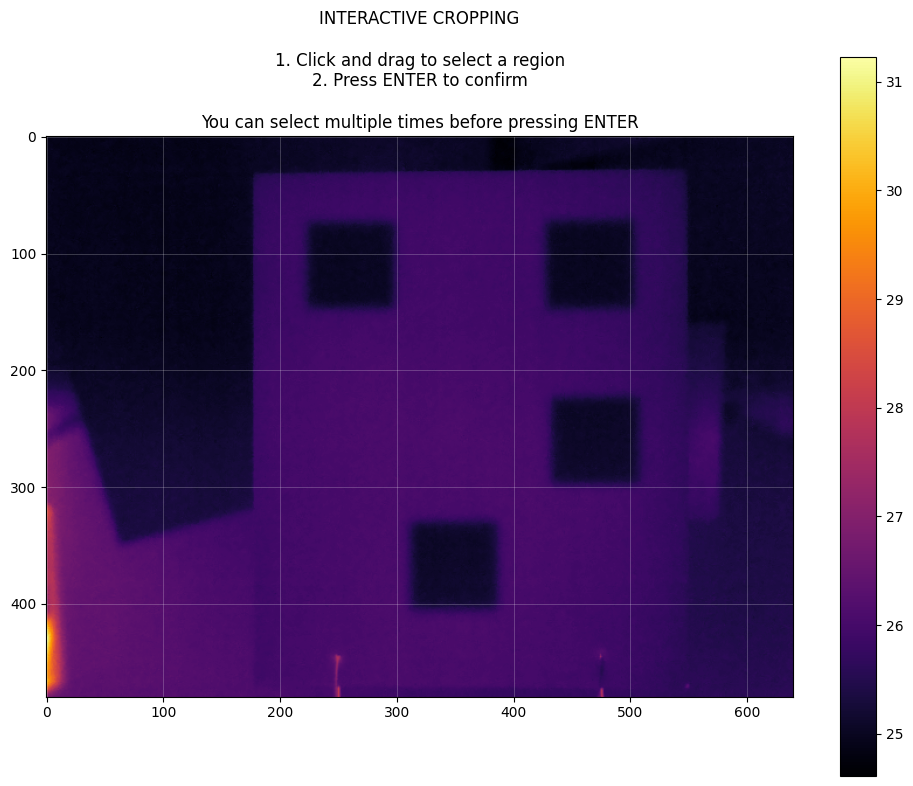


Crop region was not confirmed via ENTER key.


KeyboardInterrupt: Interrupted by user

In [4]:
#!/usr/bin/env python3
"""
Simple FLIR CSV Cropper

This script lets you:
1. Load FLIR thermal CSV files
2. Manually crop with a clear UI
3. Apply the same crop to all files in a folder
4. Downsample to 100x100
"""

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from scipy import ndimage

# Global variables to store crop coordinates
crop_coords = {'x1': 0, 'y1': 0, 'x2': 0, 'y2': 0}
crop_confirmed = False

def clean_csv(file_path):
    """Load and clean a FLIR CSV file"""
    try:
        # First try with header=None
        df = pd.read_csv(file_path, header=None)
        
        # Check if this looks like thermal data (should be mostly numeric)
        sample = df.iloc[:5, :5]
        numeric_count = 0
        total_count = 0
        
        for col in sample.columns:
            for val in sample[col]:
                total_count += 1
                try:
                    float(val)
                    numeric_count += 1
                except (ValueError, TypeError):
                    pass
        
        # If less than 70% numeric, try to find data start
        if numeric_count / total_count < 0.7:
            # Find data start by looking for rows with many commas
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            data_start = 0
            for i, line in enumerate(lines):
                if line.count(',') > 5:
                    vals = line.split(',')
                    # Check if most values are numeric
                    num_count = sum(1 for v in vals if is_numeric(v.strip()))
                    if num_count > len(vals) * 0.7:
                        data_start = i
                        break
            
            # Read again with the found start row
            df = pd.read_csv(file_path, skiprows=data_start, header=None)
        
        # Make sure all values are numeric
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Drop any completely empty columns
        df = df.dropna(axis=1, how='all')
        
        return df
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return pd.DataFrame()

def is_numeric(value):
    """Check if a string is numeric"""
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

def on_select(eclick, erelease):
    """Store the rectangle coordinates when the user selects a region"""
    global crop_coords
    crop_coords['x1'] = int(min(eclick.xdata, erelease.xdata))
    crop_coords['y1'] = int(min(eclick.ydata, erelease.ydata))
    crop_coords['x2'] = int(max(eclick.xdata, erelease.xdata))
    crop_coords['y2'] = int(max(eclick.ydata, erelease.ydata))
    
    print(f"Selected region: ({crop_coords['x1']},{crop_coords['y1']}) to ({crop_coords['x2']},{crop_coords['y2']})")

def on_key(event):
    """Handle key presses - Enter confirms, Escape cancels"""
    global crop_confirmed
    if event.key == 'enter':
        crop_confirmed = True
        plt.close()
    # Don't close on Escape - require explicit confirmation
    # Let user retry crop selection

def display_and_crop(image_data):
    """Display an image and let the user crop it interactively"""
    global crop_coords, crop_confirmed
    crop_confirmed = False
    
    # Reset crop coordinates to default (full image)
    rows, cols = image_data.shape
    crop_coords = {'x1': 0, 'y1': 0, 'x2': cols-1, 'y2': rows-1}
    
    # Create figure and display image
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(image_data, cmap='inferno')
    plt.colorbar(im, ax=ax)
    
    # Add grid lines to help with coordinate selection
    ax.grid(color='white', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Instructions
    ax.set_title('INTERACTIVE CROPPING\n\n1. Click and drag to select a region\n2. Press ENTER to confirm\n\nYou can select multiple times before pressing ENTER', fontsize=12)
    
    # Create rectangle selector
    rs = RectangleSelector(
        ax, on_select,
        useblit=True,
        button=[1],  # Left mouse button
        minspanx=5, minspany=5,
        spancoords='pixels',
        interactive=True,
        props=dict(facecolor='red', edgecolor='yellow', alpha=0.3, fill=True)
    )
    
    # Connect key press event
    plt.connect('key_press_event', on_key)
    
    plt.tight_layout()
    plt.show()
    
    # If user closed window without confirming, ask manually
    if not crop_confirmed:
        print("\nCrop region was not confirmed via ENTER key.")
        confirm = input("Do you want to use the selected region? (y/n): ")
        if confirm.lower() == 'y':
            crop_confirmed = True
    
    # Create crop slices
    row_slice = slice(crop_coords['y1'], crop_coords['y2'] + 1)
    col_slice = slice(crop_coords['x1'], crop_coords['x2'] + 1)
    
    # Apply crop
    cropped_data = image_data[row_slice, col_slice]
    
    # Show result
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original with rectangle
    im1 = ax1.imshow(image_data, cmap='inferno')
    plt.colorbar(im1, ax=ax1)
    ax1.set_title('Original with Selected Region')
    
    # Add rectangle to show selection
    from matplotlib.patches import Rectangle
    rect = Rectangle(
        (crop_coords['x1'], crop_coords['y1']),
        crop_coords['x2'] - crop_coords['x1'],
        crop_coords['y2'] - crop_coords['y1'],
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax1.add_patch(rect)
    
    # Cropped result
    im2 = ax2.imshow(cropped_data, cmap='inferno')
    plt.colorbar(im2, ax=ax2)
    ax2.set_title('Cropped Result')
    
    plt.tight_layout()
    plt.show()
    
    return cropped_data, (row_slice, col_slice)

def downsample_image(image_data, target_shape=(100, 100)):
    """Downsample image using nearest neighbor interpolation"""
    # Calculate scaling factors
    zoom_factors = (target_shape[0] / image_data.shape[0],
                   target_shape[1] / image_data.shape[1])
    
    # Apply zoom with nearest neighbor (order=0)
    downsampled = ndimage.zoom(image_data, zoom_factors, order=0)
    
    return downsampled

def process_folder():
    """Main function to process a folder of CSV files"""
    print("=" * 50)
    print("THERMAL IMAGE CROPPER AND DOWNSAMPLER")
    print("=" * 50)
    
    # Get folder path
    folder_path = input("\nEnter folder path containing CSV files: ")
    if not os.path.isdir(folder_path):
        print(f"Error: '{folder_path}' is not a valid directory.")
        return
    
    # Get file pattern
    pattern = input("Enter file pattern (default: *.csv): ") or "*.csv"
    file_paths = sorted(glob.glob(os.path.join(folder_path, pattern)))
    
    if not file_paths:
        print(f"No files found matching '{pattern}' in {folder_path}")
        return
    
    print(f"\nFound {len(file_paths)} files to process.")
    
    # Create output directory
    output_dir = os.path.join(folder_path, "processed")
    os.makedirs(output_dir, exist_ok=True)
    
    # Process first file
    first_file = file_paths[0]
    print(f"\nLoading first file: {os.path.basename(first_file)}")
    
    # Load and clean first file
    first_df = clean_csv(first_file)
    if first_df.empty:
        print("Error: Failed to load first file. Exiting.")
        return
    
    # Display shape information
    first_data = first_df.values
    print(f"Data dimensions: {first_data.shape[0]} rows × {first_data.shape[1]} columns")
    
    # Perform cropping
    print("\nDisplaying image for cropping...")
    print("Please select a crop region and press ENTER to confirm.")
    
    try:
        cropped_data, crop_region = display_and_crop(first_data)
    except Exception as e:
        print(f"Error during cropping: {e}")
        return
    
    # Downsample
    print("\nDownsampling to 100x100...")
    downsampled = downsample_image(cropped_data)
    
    # Show downsampling result
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    im1 = ax1.imshow(cropped_data, cmap='inferno')
    plt.colorbar(im1, ax=ax1)
    ax1.set_title(f'Cropped ({cropped_data.shape[0]}×{cropped_data.shape[1]})')
    
    im2 = ax2.imshow(downsampled, cmap='inferno')
    plt.colorbar(im2, ax=ax2)
    ax2.set_title('Downsampled (100×100)')
    
    plt.tight_layout()
    plt.show()
    
    # Save first file
    output_name = f"processed_{os.path.basename(first_file)}"
    output_path = os.path.join(output_dir, output_name)
    pd.DataFrame(downsampled).to_csv(output_path, index=False, header=False)
    print(f"\nSaved first processed file to: {output_path}")
    
    # Ask to process remaining files
    if len(file_paths) > 1:
        process_others = input("\nProcess remaining files with the same crop region? (y/n): ")
        if process_others.lower() != 'y':
            print("Processing stopped. Only the first file was processed.")
            return
        
        # Process remaining files
        print("\nProcessing remaining files...")
        for file_path in file_paths[1:]:
            filename = os.path.basename(file_path)
            print(f"Processing {filename}...")
            
            try:
                # Load and clean
                df = clean_csv(file_path)
                if df.empty:
                    print(f"  Error: Failed to load. Skipping.")
                    continue
                
                # Apply same crop
                data = df.values
                cropped = data[crop_region[0], crop_region[1]]
                
                # Downsample
                downsampled = downsample_image(cropped)
                
                # Save
                output_name = f"processed_{filename}"
                output_path = os.path.join(output_dir, output_name)
                pd.DataFrame(downsampled).to_csv(output_path, index=False, header=False)
                print(f"  Saved to: {output_path}")
                
            except Exception as e:
                print(f"  Error processing file: {e}")
    
    print(f"\nAll processing complete. Files saved to: {output_dir}")

if __name__ == "__main__":
    process_folder()